In [7]:
import h5py
import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import earthaccess

In [103]:
from shapely.geometry import box, Polygon
import geopandas as gpd
import contextily as ctx
import geodatasets

In [8]:
collections = earthaccess.search_datasets(keyword = 'NISAR')

for c in collections:
    umm = c.get('umm')
    print(
        umm["ShortName"],
        "-",
        umm["EntryTitle"]
    )

NISAR_L3_SME2_BETA_V1 - NISAR Beta Soil Moisture (Version 1)
NISAR_L2_GCOV_BETA_V1 - NISAR Beta Geocoded Polarimetric Covariance Product (Version 1)
NISAR_L2_GOFF_BETA_V1 - NISAR Beta Geocoded Pixel Offsets (Version 1)
NISAR_L2_GSLC_BETA_V1 - NISAR Beta Geocoded Single Look Complex Product (Version 1)
NISAR_L2_GUNW_BETA_V1 - NISAR Beta Geocoded Unwrapped Interferogram Product (Version 1)
NISAR_OE - NISAR Orbit Ephemeris
NISAR_RP - NISAR Radar Pointing
NISAR_TEC - NISAR Total Electron Content
NISAR_L1_RIFG_BETA_V1 - NISAR Beta Range Doppler Wrapped Interferogram Product (Version 1)
NISAR_L1_ROFF_BETA_V1 - NISAR Beta Range Doppler Pixel Offsets (Version 1)
NISAR_L1_RSLC_BETA_V1 - NISAR Beta Range Doppler Single Look Complex Product (Version 1) 
NISAR_L1_RUNW_BETA_V1 - NISAR Beta Range Doppler Unwrapped Interferogram Product (Version 1)
NISAR_ANC_AUX - NISAR Ancillary and Auxiliary Data
NISAR_COP - NISAR Coordinated Observation Plan
NISAR_LRCLK_UTC - NISAR L-SAR Radar Clock to UTC Convers

In [99]:
results = earthaccess.search_data(
    short_name = 'NISAR_L2_GCOV_BETA_V1'
    
)

In [100]:
len(results)

6

In [108]:
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

world = gpd.read_file(url)
india = world[world["ADMIN"] == "India"].geometry.iloc[0]

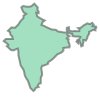

In [109]:
india

In [102]:
def granule_polygon(granule):
    points = granule["umm"]["SpatialExtent"]["HorizontalSpatialDomain"]["Geometry"]["GPolygons"][0]["Boundary"]["Points"]
    coords = [(p["Longitude"], p["Latitude"]) for p in points]

    return Polygon(coords)

In [ ]:
india_granules = []

for g in results:
    poly = granule_polygon(g)

    if poly.intersects(india):
        india_granules.append(g)

In [119]:
len(india_granules)

1

In [112]:
india_granules[0]

Collection: {'ShortName': 'NISAR_L2_GCOV_BETA_V1', 'Version': '1'}
Spatial coverage: {'GranuleLocalities': ['Land', 'Asia'], 'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 24.17615, 'Longitude': 77.30164}, {'Latitude': 22.04128, 'Longitude': 76.70841}, {'Latitude': 21.45614, 'Longitude': 79.09327}, {'Latitude': 23.57968, 'Longitude': 79.71857}, {'Latitude': 24.17615, 'Longitude': 77.30164}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-10-17T13:24:51.000000Z', 'EndingDateTime': '2025-10-17T13:25:26.999342Z'}}
Size(MB): 6554.275768280029
Data: ['https://nisar.asf.earthdatacloud.nasa.gov/NISAR/NISAR_L2_GCOV_BETA_V1/NISAR_L2_PR_GCOV_003_005_D_077_4005_DHDH_A_20251017T132451_20251017T132526_X05007_N_F_J_001/NISAR_L2_PR_GCOV_003_005_D_077_4005_DHDH_A_20251017T132451_20251017T132526_X05007_N_F_J_001.h5']

In [114]:
import os

In [ ]:
earthaccess.login(persist=True)

In [117]:
earthaccess.download(india_granules[0], os.getcwd())

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['c:\\Users\\ADM_IN\\Desktop\\Personal\\sanjay\\projects\\NISAR\\NISAR_L2_PR_GCOV_003_005_D_077_4005_DHDH_A_20251017T132451_20251017T132526_X05007_N_F_J_001.h5']

***

***

In [2]:
nis_path = 'NISAR_L2_PR_GCOV_003_005_D_077_4005_DHDH_A_20251017T132451_20251017T132526_X05007_N_F_J_001.h5'

In [3]:
base = "/science/LSAR/GCOV/grids/frequencyA"

pols = {}

with h5py.File(nis_path, "r") as f:
    available_pols = [i.astype('U') for i in f[f'{base}/listOfPolarizations'][:]]
    
    for i in available_pols:
        pol = f[f'{base}/{i+i}'][:]
        pol_db = 10 * np.log10(pol + 1e-18)
        pols[i] = pol_db

    xcoords = f[f'{base}/xCoordinates'][:]
    ycoords = f[f'{base}/yCoordinates'][:]
    pols['x'] = xcoords
    pols['y'] = ycoords
    

In [4]:
HH = pols.get('HH')
HV = pols.get('HV')

In [5]:
stacked = np.dstack([HH, HV])

In [19]:
stacked.shape

(33408, 34056, 2)

In [6]:
pol_da = xr.DataArray(data = stacked,
             dims = ['y', 'x', 'variable'],
             coords = {
                 'y' : pols.get('y'),
                 'x' : pols.get('x'),
                 'variable' : ['HH', 'HV']
             })

In [7]:
pol_da

<xarray.DataArray (y: 33408, x: 34056, variable: 2)> Size: 9GB
array([[[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
...
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]]], dtype=float32)
Coordinates:
  * y         (y) float64 267kB 2.689e+06 2.689e+06 ... 2.355e+06 2.355e+06
  * x         (x) float64 272kB 6.646e+05 6.646e+05 ... 1.005e+06 1.005e+06
  * variable  (variable) <U2 16B 'HH' 'HV'

In [8]:
pol_da.shape

(33408, 34056, 2)

In [9]:
pol_da.coords

Coordinates:
  * y         (y) float64 267kB 2.689e+06 2.689e+06 ... 2.355e+06 2.355e+06
  * x         (x) float64 272kB 6.646e+05 6.646e+05 ... 1.005e+06 1.005e+06
  * variable  (variable) <U2 16B 'HH' 'HV'

In [10]:
pol_da.dims

('y', 'x', 'variable')

In [11]:
pol_da.rio.write_crs("epsg:32643", inplace=True)

<xarray.DataArray (y: 33408, x: 34056, variable: 2)> Size: 9GB
array([[[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
...
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 267kB 2.689e+06 2.689e+06 ... 2.355e+06 2.355e+06
  * x            (x) float64 272kB 6.646e+05 6.646e+05 ... 1.005e+06 1.005e+06
  * variable     (variable) <U2 16B 'HH' 'HV'
    spatial_ref  int32 4B 0

In [19]:
low_lat = pol_da.y.min().item()
low_lon = pol_da.x.min().item()
high_lat = pol_da.y.max().item()
high_lon = pol_da.x.max().item()

In [20]:
print(low_lat, low_lon)
print(high_lat, low_lon)
print(high_lat, high_lon)
print(low_lat, high_lon)

2355125.0 664565.0
2689195.0 664565.0
2689195.0 1005115.0
2355125.0 1005115.0


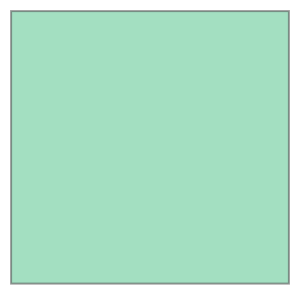

In [23]:
bbox = box(low_lon, low_lat, high_lon, high_lat)
bbox

In [27]:
bbox_gdf = gpd.GeoDataFrame({'geometry' : [bbox]}, crs = 'EPSG:32643')
bbox_gdf

geometry
0  POLYGON ((1.01e+06 2.36e+06, 1.01e+06 2.69e+06...

In [ ]:
bbox_gdf.explore()

<Axes: >

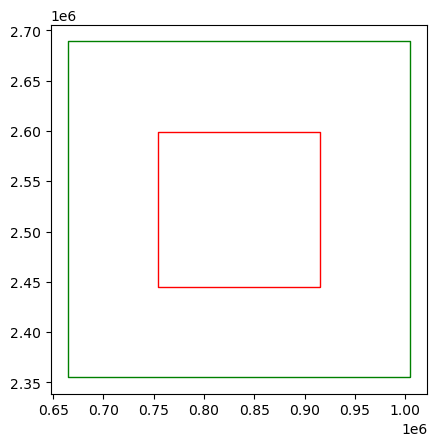

In [35]:
shrinked = bbox_gdf.buffer(-90000)

ax = bbox_gdf.plot(facecolor = 'None', edgecolor = 'green')
shrinked.plot(ax = ax, facecolor = 'None', edgecolor = 'red')

In [ ]:
ax = bbox_gdf.explore(color='green')
shrinked.explore(ax = ax, color= 'red')

In [37]:
pol_da_clipped = pol_da.rio.clip(shrinked.geometry, shrinked.crs, drop = True)

In [38]:
pol_da_clipped.shape

(15408, 16055, 2)

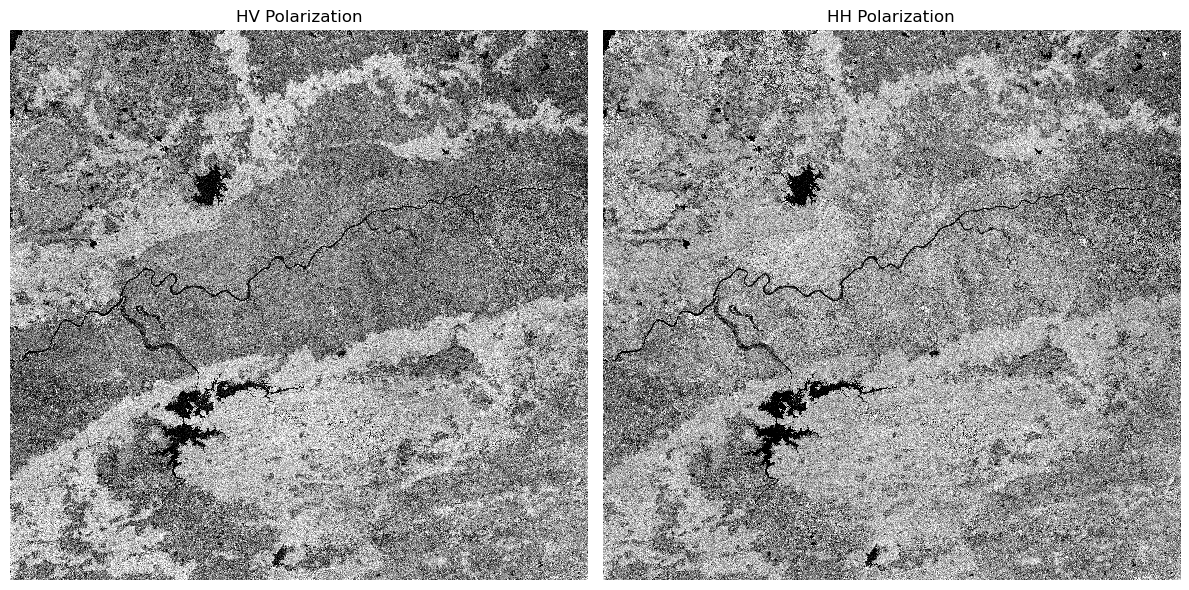

In [43]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

pol_da_clipped.sel(variable = 'HV').plot.imshow(ax = ax[0], robust = True, cmap = 'gray', add_colorbar=False)
ax[0].set_title('HV Polarization')
ax[0].axis('off')

pol_da_clipped.sel(variable = 'HH').plot.imshow(ax = ax[1], robust = True, cmap = 'gray', add_colorbar=False)
ax[1].set_title('HH Polarization')
ax[1].axis('off')

plt.tight_layout()

In [2]:
pol_da_clipped = rxr.open_rasterio('nisar_da.tif')

In [3]:
pol_da_clipped = pol_da_clipped.assign_coords(band=["HH", "HV"])
pol_da_clipped.coords

Coordinates:
  * x            (x) float64 128kB 7.546e+05 7.546e+05 ... 9.151e+05 9.151e+05
  * y            (y) float64 123kB 2.599e+06 2.599e+06 ... 2.445e+06 2.445e+06
    spatial_ref  int32 4B 0
  * band         (band) <U2 16B 'HH' 'HV'

In [4]:
pol_da_clipped.sel(band = ['HH', 'HV', 'HH'])

<xarray.DataArray (band: 3, y: 15408, x: 16055)> Size: 3GB
[742126320 values with dtype=float32]
Coordinates:
  * x            (x) float64 128kB 7.546e+05 7.546e+05 ... 9.151e+05 9.151e+05
  * y            (y) float64 123kB 2.599e+06 2.599e+06 ... 2.445e+06 2.445e+06
    spatial_ref  int32 4B 0
  * band         (band) <U2 24B 'HH' 'HV' 'HH'
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

(754570.0, 915120.0, 2445120.0, 2599200.0)

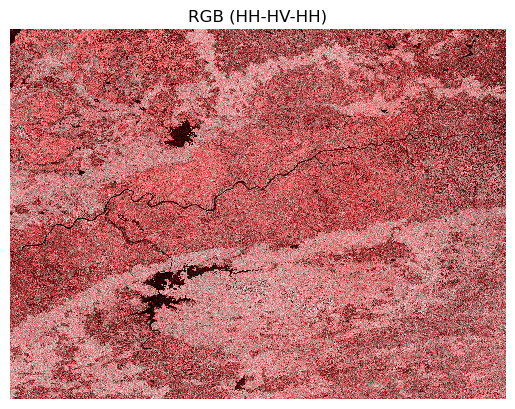

In [11]:
pol_da_clipped.sel(band = ['HH', 'HV', 'HV']).plot.imshow(robust = True, cmap = 'gray', add_colorbar=False)
plt.title('RGB (HH-HV-HH)')
plt.axis('off')

(754570.0, 915120.0, 2445120.0, 2599200.0)

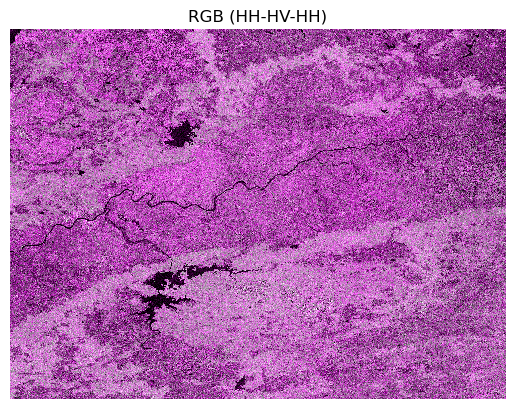

In [10]:
pol_da_clipped.sel(band = ['HH', 'HV', 'HH']).plot.imshow(robust = True, cmap = 'gray', add_colorbar=False)
plt.title('RGB (HH-HV-HH)')
plt.axis('off')

In [49]:
 pol_da_clipped.transpose('variable', 'y', 'x').rio.to_raster('nisar_da.tif',
      compress="LZW",
      tiled=True
  )

In [2]:
nisar_da = rxr.open_rasterio('nisar_da.tif')

In [3]:
nisar_da = nisar_da.assign_coords(band = ['HH', 'HV'])

In [4]:
nisar_da

<xarray.DataArray (band: 2, y: 15408, x: 16055)> Size: 2GB
[494750880 values with dtype=float32]
Coordinates:
  * x            (x) float64 128kB 7.546e+05 7.546e+05 ... 9.151e+05 9.151e+05
  * y            (y) float64 123kB 2.599e+06 2.599e+06 ... 2.445e+06 2.445e+06
    spatial_ref  int32 4B 0
  * band         (band) <U2 16B 'HH' 'HV'
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        27.416439056396
    STATISTICS_MEAN:           -8.7918474915236
    STATISTICS_MINIMUM:        -33.602272033691
    STATISTICS_STDDEV:         3.8811594728317
    STATISTICS_VALID_PERCENT:  99.98
    scale_factor:              1.0
    add_offset:                0.0

In [5]:
HH = nisar_da.sel(band = 'HH')
HV = nisar_da.sel(band = 'HV')

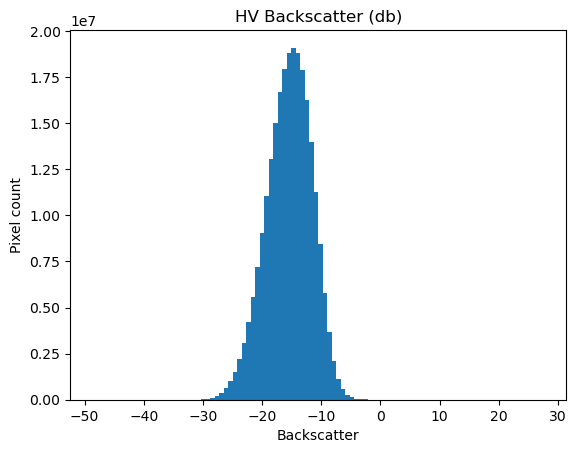

In [6]:
valid = HV.values.ravel()
valid = valid[~np.isnan(valid)]


plt.hist(valid, bins = 100)
plt.xlabel('Backscatter')
plt.ylabel('Pixel count')
plt.title('HV Backscatter (db)')
plt.show()

In [9]:
forest_nan = xr.where(HV > -15, 1, np.nan)
forest_non_forest = xr.where(HV > -15, 1, 0)

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

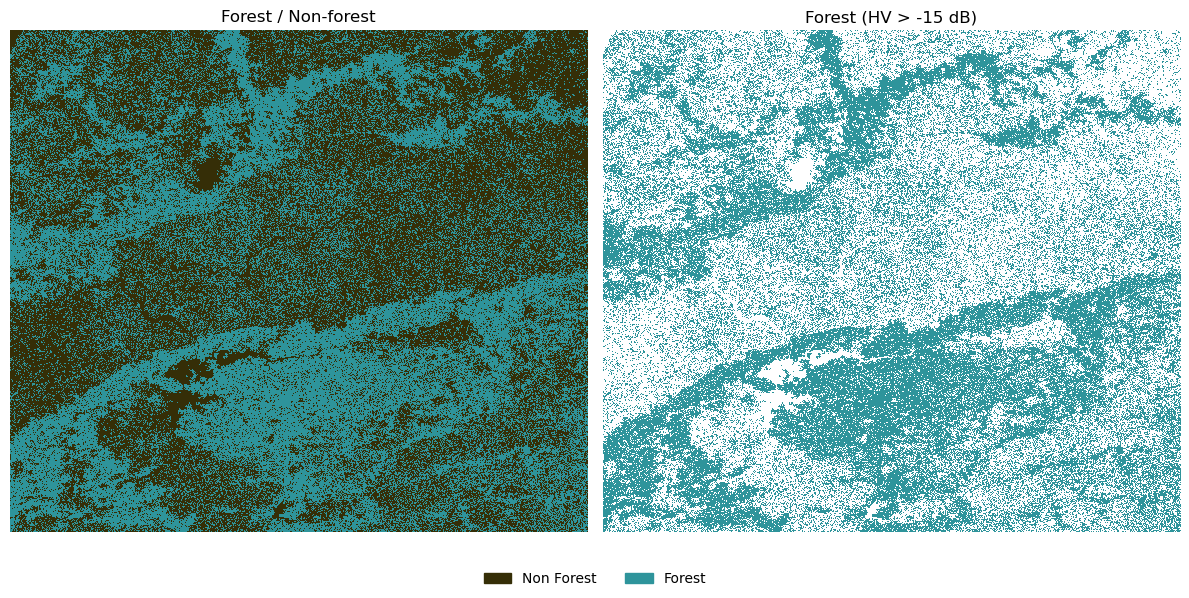

In [19]:
colors = [
    "#352E07",
    "#2E949B"
    
]

cmap = ListedColormap(colors)

legend_patches = [
    mpatches.Patch(color=colors[0], label="Non Forest"),
    mpatches.Patch(color=colors[1], label="Forest")]

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

forest_non_forest.plot.imshow(ax = ax[0], cmap = cmap, vmin=0,vmax=1, add_colorbar=False)
ax[0].set_title('Forest / Non-forest')
ax[0].axis('off')

forest_nan.plot.imshow(ax = ax[1], cmap= ListedColormap(colors[1]), add_colorbar=False)
ax[1].set_title('Forest (HV > -15 dB)')
ax[1].axis('off')

fig.legend(
    handles=legend_patches,
    loc="lower center",
    ncol=2,
    frameon=False
)

plt.tight_layout(rect=[0, 0.08, 1, 1])

In [26]:
forest_nan.shape

(15408, 16055)

In [22]:
forest_nan.rio.to_raster('forest_cover.tif')

In [4]:
forest_nan = rxr.open_rasterio('forest_cover.tif')

In [4]:
forest_nan.squeeze()[9000:12000, 4000:7500].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 1.,  1., nan, ...,  1., nan, nan],
       [nan,  1., nan, ...,  1., nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

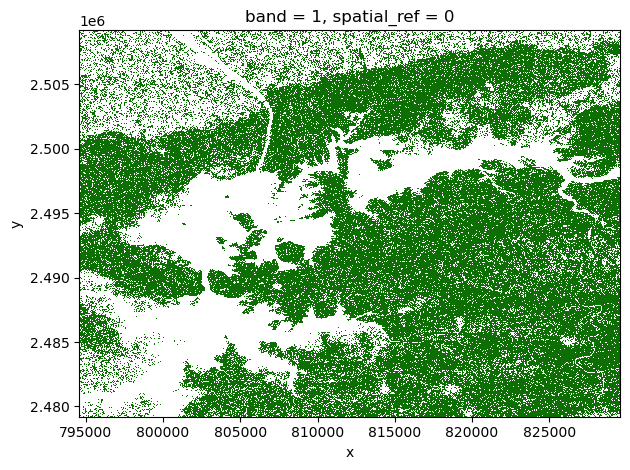

In [5]:
forest_nan.squeeze()[9000:12000, 4000:7500].plot.imshow(cmap= ListedColormap("#0D6E04"), add_colorbar=False)
plt.tight_layout()

In [5]:
forest_nan.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [6]:
forest_nan = forest_nan.rio.write_crs("EPSG:32643")

In [7]:
forest_nan.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]')

In [8]:
forest_wgs84 = forest_nan.rio.reproject("EPSG:4326")

In [9]:
forest_wgs84.rio.bounds()

(77.46731711649781, 22.061541953619827, 79.06196462409758, 23.483029502453174)

In [21]:
forest_nan.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]')

In [22]:
forest_nan.rio.transform()

Affine(10.0, 0.0, 754570.0,
       0.0, -10.0, 2599200.0)

In [25]:
forest_nan.squeeze()[9000:12000, 4000:7500].rio.to_raster('forest_cover_subset.tif', compression = 'LZW', tiled = True)

In [3]:
forest_subset = rxr.open_rasterio('forest_cover_subset.tif')

In [4]:
forest_bin = forest_subset.fillna(0).astype("uint8")

In [2]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape


In [5]:
results = (
    {"properties": {"value": v}, "geometry": s}
    for s, v in shapes(
        forest_bin.values,
        mask=forest_bin.values == 1,
        transform=forest_bin.rio.transform()
    )
)

In [6]:
gdf = gpd.GeoDataFrame.from_features(results, crs=forest_bin.rio.crs)

In [7]:
gdf.shape

(120243, 2)

In [8]:
gdf.head(2)

geometry  value
0  POLYGON ((7.95e+05 2.51e+06, 7.95e+05 2.51e+06...    1.0
1  POLYGON ((7.95e+05 2.51e+06, 7.95e+05 2.51e+06...    1.0

In [7]:
gdf.to_crs('EPSG:4326', inplace=True)

In [8]:
gdf.to_parquet('forest_polygons.parquet')

In [10]:
forest_poly = gpd.read_parquet('forest_polygons.parquet')

In [11]:
forest_poly.head()

geometry  value
0  POLYGON ((77.867 22.664, 77.867 22.664, 77.867...    1.0
1  POLYGON ((77.868 22.664, 77.868 22.664, 77.868...    1.0
2  POLYGON ((77.868 22.664, 77.868 22.664, 77.868...    1.0
3  POLYGON ((77.869 22.664, 77.869 22.664, 77.869...    1.0
4  POLYGON ((77.869 22.664, 77.869 22.664, 77.869...    1.0

In [13]:
import leafmap.leafmap as leafmap

In [14]:
m = leafmap.Map()

In [16]:
m.add_gdf(forest_poly)

In [17]:
m

Map(bottom=454.0, center=[19.973348786110613, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', '…